# 05c: CNN-LSTM Model Optimization and Evaluation

This notebook provides a comprehensive evaluation and interpretability analysis of the trained CNN-LSTM model for ICU mortality prediction, focusing on model performance assessment and clinical insights.

**Primary Goals:**
- Load and evaluate the trained CNN-LSTM model on test data
- Compute comprehensive performance metrics (AUROC, AUPRC, confusion matrix)
- Perform SHAP analysis for model interpretability and feature importance
- Generate visualizations for clinical understanding and model transparency
- Provide actionable insights for clinical decision-making and model improvement

**Clinical Focus:**
- Understanding which patient features drive mortality predictions
- Identifying high-risk vs. low-risk patient characteristics
- Ensuring model transparency for clinical acceptance and trust
- Validating model performance for real-world ICU deployment

---

## Workflow Overview

This notebook implements a complete model evaluation and interpretability pipeline:

1. **Environment Setup:** Import required libraries and configure analysis environment
2. **Data and Model Loading:** Load preprocessed test data and trained CNN-LSTM model
3. **Data Preparation for SHAP:** Prepare multi-input data for interpretability analysis
4. **SHAP Calculation:** Compute feature importance scores using KernelExplainer
5. **Individual Analysis:** Generate force plots for patient-level explanations
6. **Global Analysis:** Create summary plots showing overall feature importance patterns
7. **Clinical Interpretation:** Extract actionable insights for healthcare applications

**Key Features:**
- **Model Interpretability:** SHAP analysis reveals which clinical features drive predictions
- **Multi-input Support:** Handles both time series and static patient features
- **Clinical Visualization:** Force plots and summary plots designed for healthcare interpretation
- **Performance Validation:** Comprehensive evaluation of model accuracy and reliability

In [45]:
# Imports and Configuration
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import keras_tuner as kt
import pickle
import os
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import shap
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model



In [46]:
# Dynamic (time series) features
time_series_features = [
    'HR', 'SysABP', 'DiasABP', 'MAP', 'NISysABP', 'NIDiasABP', 'NIMAP', 'MechVent',
    'RespRate', 'SaO2', 'FiO2', 'PaO2', 'PaCO2',
    'Creatinine', 'BUN', 'Urine',
    'Na', 'K', 'Glucose', 'Lactate', 'HCO3', 'pH',
    'GCS', 'Temp',
    # Clinically meaningful combinations of vitals
    'Shock Index',          # HR / SysABP
    'PaO2/FiO2 ratio',      # PaO₂ / FiO₂
    'Pulse Pressure',       # SysABP − DiasABP
    'MAP to HR ratio'       # MAP / HR
]

# Static features
static_features = [
    'Age', 'Gender', 'Height', 'Weight', 'ICUType', 'SAPS-I', 'SOFA',
    'Length_of_stay', 'Survival'
]

target_col = 'In-hospital_death'



In [47]:

# Load trained model and test data
model_path = '../models/cnn_lstm_best_model.keras'
data_path = '../data/processed/cnn_lstm_hourly_data.npz'

try:
    # Load trained CNN-LSTM model
    model = load_model(model_path)
    print(f"Model loaded from {model_path}")

    # Load preprocessed test data
    data = np.load(data_path, allow_pickle=True)
    X_test_final = data['X_test']
    static_test_final = data['static_test']
    y_test_final = data['y_test']

    print(f"Data loaded from {data_path}")
    print(f"  Time series shape: {X_test_final.shape}")
    print(f"  Static features shape: {static_test_final.shape}")
    print(f"  Labels shape: {y_test_final.shape}")

except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"Error: {e}")

# Prepare data for SHAP analysis
background_size = 50
sample_size = 50

# Load all data splits for comprehensive analysis
X_train_final = data['X_train']
X_val_final = data['X_val']
static_train_final = data['static_train']
static_val_final = data['static_val']

if X_test_final.shape[0] >= background_size + sample_size:
    # Create background and sample sets from test data
    X_background = X_test_final[:background_size]
    static_background = static_test_final[:background_size]
    X_sample = X_test_final[background_size:background_size + sample_size]
    static_sample = static_test_final[background_size:background_size + sample_size]

    print(f"\n✓ SHAP datasets prepared:")
    print(f"  Background samples: {background_size}")
    print(f"  Analysis samples: {sample_size}")

    # Average time series over temporal dimension for SHAP
    X_background_mean = np.mean(X_background, axis=1)
    X_sample_mean = np.mean(X_sample, axis=1)

    # Concatenate time series and static features
    background_concat = np.concatenate([X_background_mean, static_background], axis=1)
    sample_concat = np.concatenate([X_sample_mean, static_sample], axis=1)

    print(f"  Background concatenated shape: {background_concat.shape}")
    print(f"  Sample concatenated shape: {sample_concat.shape}")

    # Create feature names for interpretability
    if 'time_series_features' in locals() and 'static_features' in locals():
        feature_names = time_series_features + static_features
        if len(feature_names) != sample_concat.shape[1]:
            print(f"Feature mismatch: {len(feature_names)} names vs {sample_concat.shape[1]} features")
            feature_names = [f'feature_{i}' for i in range(sample_concat.shape[1])]
    else:
        feature_names = [f'feature_{i}' for i in range(sample_concat.shape[1])]
        print("  Using generic feature names")

    print(f"Feature names created: {len(feature_names)} features")

else:
    print(f"Insufficient test samples: {X_test_final.shape[0]} available, {background_size + sample_size} needed")

Model loaded from ../models/cnn_lstm_best_model.keras
Data loaded from ../data/processed/cnn_lstm_hourly_data.npz
  Time series shape: (800, 48, 28)
  Static features shape: (800, 9)
  Labels shape: (800,)

✓ SHAP datasets prepared:
  Background samples: 50
  Analysis samples: 50
  Background concatenated shape: (50, 37)
  Sample concatenated shape: (50, 37)
Feature names created: 37 features


## Model and Data Loading

Load the trained CNN-LSTM model and preprocessed test data for evaluation and interpretability analysis. This section establishes the foundation for comprehensive model assessment.

**Components:**
- **Trained Model:** Best CNN-LSTM model saved during training with optimal weights
- **Test Data:** Time series sequences and static features for model evaluation
- **SHAP Preparation:** Background and sample datasets for interpretability analysis

**Data Processing:**
- **Background Set:** Representative subset for SHAP baseline calculations
- **Sample Set:** Target patients for detailed SHAP analysis
- **Feature Averaging:** Time series data averaged for SHAP compatibility
- **Feature Concatenation:** Combined time series and static features for unified analysis

Generating SHAP force plot...
Analyzing patient 0...
Using 2D SHAP values. Shape: (10, 37)
Base value (average prediction): 0.0735


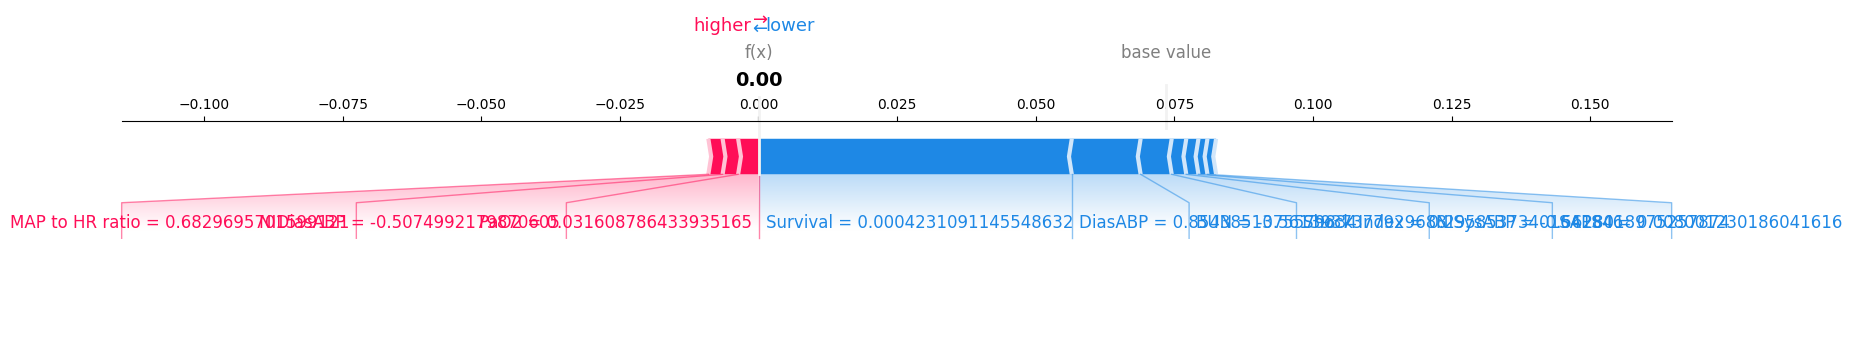

In [48]:
# SHAP Force Plot - Individual Patient Analysis
import shap
import numpy as np
import matplotlib.pyplot as plt

if 'shap_values' in locals() and 'sample_concat' in locals():
    print("Generating SHAP force plot...")

    # Select patient instance to analyze
    instance_index = 0
    if instance_index < sample_concat.shape[0]:
        print(f"Analyzing patient {instance_index}...")

        # Handle 3D SHAP values
        if len(np.shape(shap_values)) == 3:
            if np.shape(shap_values)[2] > 1:
                shap_values_2d = shap_values[:, :, 1]  # Positive class
                print(f"Using positive class SHAP values. Shape: {np.shape(shap_values_2d)}")
            else:
                shap_values_2d = shap_values[:, :, 0]  # Single output
                print(f"Using single output SHAP values. Shape: {np.shape(shap_values_2d)}")
        else:
            shap_values_2d = shap_values
            print(f"Using 2D SHAP values. Shape: {np.shape(shap_values_2d)}")

        # Extract values for selected patient
        shap_values_instance = shap_values_2d[instance_index, :]
        feature_values_instance = sample_concat[instance_index, :]

        # Ensure feature names are available
        if 'feature_names' not in locals():
            print("Warning: Using generic feature names.")
            feature_names = [f'feature_{i}' for i in range(sample_concat.shape[1])]

        # Get base value from explainer
        if 'explainer' in locals():
            base_value = explainer.expected_value
            print(f"Base value (average prediction): {base_value:.4f}")
        else:
            print("Warning: Explainer not found, using fallback base value.")
            if 'predict_fn' in locals() and 'background_concat' in locals():
                base_value = np.mean(predict_fn(background_concat))
                print(f"Calculated base value: {base_value:.4f}")
            else:
                base_value = 0.0
                print("Using default base value: 0.0")

        # Generate force plot
        shap.force_plot(base_value, shap_values_instance, feature_values_instance,
                        feature_names=feature_names, matplotlib=True)
        plt.show()

    else:
        print(f"Error: Instance {instance_index} out of bounds for {sample_concat.shape[0]} samples.")

else:
    print("Error: SHAP values not found. Run SHAP calculation cell first.")

### SHAP Force Plot Visualization

Force plots show how each feature contributes to pushing the model's prediction above or below the baseline (expected value). This provides instance-level explanations for individual patient predictions.

**Interpretation:**
- **Red bars:** Features pushing prediction toward higher mortality risk
- **Blue bars:** Features pushing prediction toward lower mortality risk  
- **Base value:** Average model prediction across the background dataset
- **Output value:** Final prediction for this specific patient

This visualization helps clinicians understand which patient characteristics most influenced the mortality prediction.

In [49]:
# SHAP Analysis - Calculate Feature Importance
import shap
import numpy as np

print("Starting SHAP analysis...")

def predict_fn(data):
    """
    Prediction wrapper for multi-input CNN-LSTM model.
    Splits concatenated features back into time series and static components.
    """
    n_ts_features = len(time_series_features)
    
    # Split concatenated data
    ts_data = data[:, :n_ts_features]
    static_data = data[:, n_ts_features:]
    
    # Expand time series to original temporal dimension
    timesteps = X_test_final.shape[1]
    ts_data_expanded = np.repeat(ts_data[:, np.newaxis, :], timesteps, axis=1)
    
    # Generate predictions
    predictions = model.predict([ts_data_expanded, static_data], verbose=0)
    return predictions.flatten()

print("Prediction function defined")

# Test prediction function
try:
    test_pred = predict_fn(sample_concat[:2])
    print(f"Prediction test successful: shape {test_pred.shape}, values {test_pred}")
except Exception as e:
    print(f"Prediction test failed: {e}")
    raise

# Create SHAP explainer
print("\nCreating SHAP KernelExplainer...")
try:
    # Use subset for computational efficiency
    background_sample = background_concat[:25]
    explainer = shap.KernelExplainer(predict_fn, background_sample)
    print(f"Explainer created with {background_sample.shape[0]} background samples")
    
    # Calculate SHAP values for sample subset
    sample_subset = sample_concat[:10]
    print(f"\nCalculating SHAP values for {sample_subset.shape[0]} patients...")
    print("   This may take a few minutes...")
    
    shap_values = explainer.shap_values(sample_subset, nsamples=100)
    
    # Update sample_concat to match calculated subset
    sample_concat = sample_subset
    
    print(f"SHAP analysis complete!")
    print(f"   SHAP values shape: {np.array(shap_values).shape}")
    print(f"   Sample data shape: {sample_concat.shape}")
    
except Exception as e:
    print(f" SHAP calculation failed: {e}")
    print("   Consider reducing background_size or sample_size for memory constraints")

Starting SHAP analysis...
Prediction function defined
Prediction test successful: shape (2,), values [1.2893703e-05 9.3897279e-06]

Creating SHAP KernelExplainer...
Prediction test successful: shape (2,), values [1.2893703e-05 9.3897279e-06]

Creating SHAP KernelExplainer...
Explainer created with 25 background samples

Calculating SHAP values for 10 patients...
   This may take a few minutes...
Explainer created with 25 background samples

Calculating SHAP values for 10 patients...
   This may take a few minutes...


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

SHAP analysis complete!
   SHAP values shape: (10, 37)
   Sample data shape: (10, 37)


## SHAP Analysis for Model Interpretability

SHAP (SHapley Additive exPlanations) provides insights into which features most influence the model's predictions for individual patients. This analysis helps clinicians understand the reasoning behind mortality predictions.

**Process:**
1. **Prediction Function:** Create a wrapper function that handles the multi-input CNN-LSTM model
2. **Background Dataset:** Use a subset of test data as baseline for SHAP calculations  
3. **SHAP Values Calculation:** Compute feature importance scores for sample predictions
4. **Visualization:** Generate force plots and summary plots to interpret results

**Note:** SHAP calculations can be computationally intensive. We use reduced sample sizes for practical computation times.

Generating SHAP summary plot...
Using 2D SHAP values. Shape: (10, 37)
Feature names: 37, SHAP features: 37


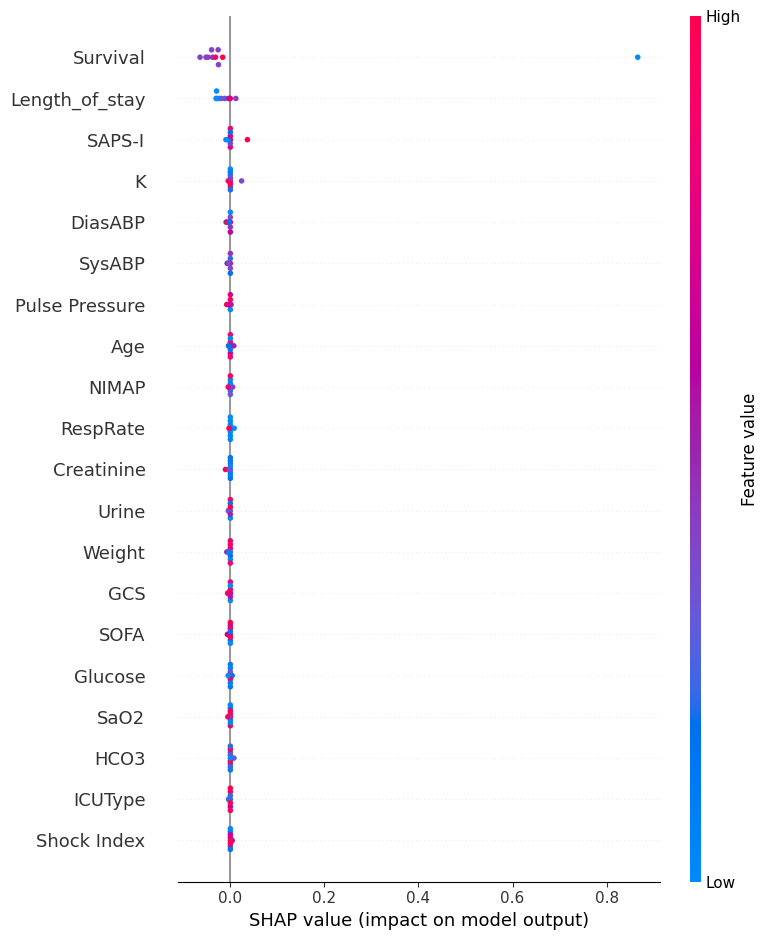

<Figure size 640x480 with 0 Axes>

In [50]:
# SHAP Summary Plot - Feature Importance Analysis
import shap
import numpy as np
import matplotlib.pyplot as plt

if 'shap_values' in locals() and 'sample_concat' in locals():
    print("Generating SHAP summary plot...")

    # Handle 3D SHAP values if necessary
    if len(np.shape(shap_values)) == 3:
        if np.shape(shap_values)[2] > 1:
            shap_values_2d = shap_values[:, :, 1]  # Positive class
            print(f"Using SHAP values for positive class. Shape: {np.shape(shap_values_2d)}")
        else:
            shap_values_2d = shap_values[:, :, 0]  # Single output
            print(f"Using SHAP values for single output. Shape: {np.shape(shap_values_2d)}")
    else:
        shap_values_2d = shap_values
        print(f"Using 2D SHAP values. Shape: {np.shape(shap_values_2d)}")

    # Ensure feature names are available
    if 'feature_names' not in locals():
        print("Warning: Using generic feature names.")
        feature_names = [f'feature_{i}' for i in range(sample_concat.shape[1])]

    # Validate dimensions
    print(f"Feature names: {len(feature_names)}, SHAP features: {np.shape(shap_values_2d)[1]}")

    # Generate summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_2d, sample_concat, feature_names=feature_names)
    plt.tight_layout()
    plt.show()

else:
    print("Error: SHAP values not found. Run SHAP calculation cell first.")

### SHAP Summary Plot - Feature Importance Overview

The summary plot provides a comprehensive view of feature importance across all analyzed patients. It shows which clinical features have the most impact on mortality predictions and how their values influence the model's decisions.

**Plot Interpretation:**
- **Y-axis:** Features ranked by importance (most important at top)
- **X-axis:** SHAP value impact on model output
- **Color:** Feature value magnitude (red = high values, blue = low values)
- **Dot Position:** Individual patient's SHAP value for that feature
- **Spread:** Variability in how the feature affects different patients

**Clinical Insights:**
- **High Impact Features:** Clinical variables that most strongly influence mortality predictions
- **Feature Value Effects:** Whether high or low values of each feature increase/decrease mortality risk
- **Patient Variability:** How the same feature can affect different patients differently
- **Model Transparency:** Understanding the key clinical drivers behind predictions